In [1]:
import control
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from dynamic_systems.controller import PID
from dynamic_systems.simulation import TwoTanks
from dynamic_systems.simulation import CSTR
from dynamic_systems.identification import FOPTD

from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['mathtext.fontset'] = 'custom'  
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'  
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'  
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'  
plt.rcParams['font.size'] = 16  
plt.rcParams['mathtext.fontset'] = 'stix'  
plt.rcParams['font.family'] = 'STIXGeneral' 

plt.style.use('science')

# Auxiliary Functions

## StepFn input

In [2]:
def step_fn(t, obs, u=1):
    if t >= 0:
        return u
    else:
        return 0

In [3]:
zeros_input = partial(step_fn, u=0)

## Jacobian Matrix

In [4]:
from scipy.constants import g

def jacobian(xss, A1=1, A2=1, a12=0.1, a13=0.1, a23=0.1): 
    return np.array([ 
        [- np.sqrt(2 * g) * (a12 + a13) / (2 * A1 * np.sqrt(xss[0])), 0], 
        [a12 * np.sqrt(2 * g) / (2 * A2 * np.sqrt(xss[0])), - a23 * np.sqrt(2 * g) / (2 * A2 * np.sqrt(xss[1]))] 
    ]) 

## Direct Synthesis Tuning Rules

In [5]:
def tuning_rules(tau, K, theta, tau_c=1.0):
    Kc = tau / (K * (tau_c + theta))
    Ki = Kc / tau
    Kd = 0
    return Kc, Ki, Kd

## Tuning Metrics

In [6]:
def total_variation(u):
    return sum(abs(np.diff(u)))


def IAE(y, r, dt):
    return sum(abs(r - y)) * dt


def rise_time(t, y):
    t2 = t[np.max(np.where(y <= 0.9 * y[-1])[0])]
    t1 = t[np.min(np.where(y >= 0.1 * y[-1])[0])]

    return t2 - t1


def overshooting(y):
    return ((y.max() / y[-1]) - 1) * 100

# Two Tanks

## Free-Response

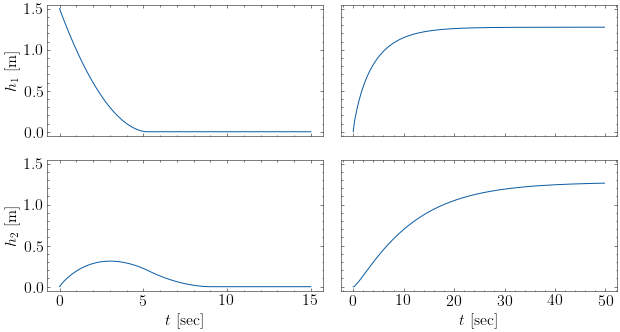

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(9, 5), sharex='col', sharey='row')

t = np.linspace(0, 15, 100)
two_tanks = TwoTanks(fault_type=0, measurement_noise=0.0, process_noise=0.0)
u, x, y = two_tanks(t, [1.5, 0.0], zeros_input)

axes[0, 0].plot(t, x[:, 0])
axes[0, 0].set_ylabel(r'$h_{1}$ [m]')
axes[0, 0].set_ylim([-0.05, 1.55])
axes[0, 0].set_yticks([0.0, 0.5, 1.0, 1.5])
axes[1, 0].plot(t, x[:, 1])
axes[1, 0].set_ylabel(r'$h_{2}$ [m]')
axes[1, 0].set_ylim([-0.05, 1.55])
axes[1, 0].set_yticks([0.0, 0.5, 1.0, 1.5])
axes[1, 0].set_xlabel(r'$t$ [sec]')

t0 = 0.0
tf = 50.0
dt = 0.2
t = np.arange(t0, tf, dt)

two_tanks = TwoTanks(fault_type=0, measurement_noise=0.0, process_noise=0.0)
u, x, y = two_tanks(t, [0.0, 0.0], step_fn)


axes[0, 1].plot(t, x[:, 0])
axes[1, 1].plot(t, x[:, 1])
axes[1, 1].set_xlabel(r'$t$ [sec]')
axes[1, 1].set_xticks([0, 10, 20, 30, 40, 50])

plt.tight_layout()
plt.savefig('./Figures/Ch2/SysSim.pdf', transparent=True)

## Linearization Comparison

RMSE h1: 0.49647452170258977
RMSE h2: 0.900500514714008


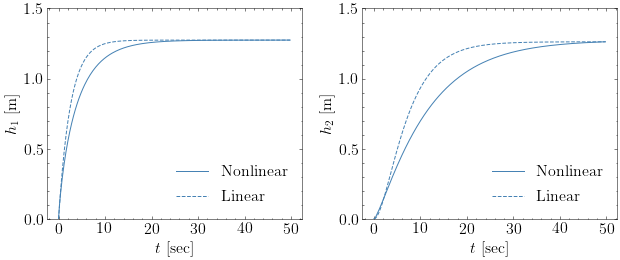

In [10]:
A = jacobian(x[-1, :], A1=1, A2=1, a12=0.1, a13=0.1, a23=0.1)
B = np.array([[1 / 1], [0]])
C = np.array([[0, 1]])
D = np.array([[0]])

sys = control.ss(A, B, C, D)
_, ylin, xlin = control.forced_response(sys, T=t, X0=-x[-1, :], U=0, transpose=True)
xlin = xlin + x[-1, :]
rmse_h1 = np.sqrt(np.sum((xlin[:, 0] - x[:, 0]) ** 2) * (t[1] - t[0]))
rmse_h2 = np.sqrt(np.sum((xlin[:, 1] - x[:, 1]) ** 2) * (t[1] - t[0]))
print('RMSE h1: {}'.format(rmse_h1))
print('RMSE h2: {}'.format(rmse_h2))

fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
axes[0].plot(t, x[:, 0], color='steelblue', label='Nonlinear')
axes[0].plot(t, xlin[:, 0], color='steelblue', linestyle='dashed', label='Linear')
axes[0].set_ylabel(r'$h_{1}$ [m]')
axes[0].set_xlabel(r'$t$ [sec]')
axes[0].set_ylim([0.0, 1.5])
axes[0].set_yticks([0.0, 0.5, 1.0, 1.5])
axes[1].set_ylim([0.0, 1.5])
axes[1].set_yticks([0.0, 0.5, 1.0, 1.5])
axes[1].plot(t, x[:, 1], color='steelblue', label='Nonlinear')
axes[1].plot(t, xlin[:, 1], color='steelblue', linestyle='dashed', label='Linear')
axes[1].set_ylabel(r'$h_{2}$ [m]')
axes[1].set_xlabel(r'$t$ [sec]')
# axes[0].set_xlabel(r't')
axes[0].set_ylim([0.0, 1.5])
axes[0].set_yticks([0.0, 0.5, 1.0, 1.5])
axes[1].set_ylim([0.0, 1.5])
axes[1].set_yticks([0.0, 0.5, 1.0, 1.5])
axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')
axes[0].set_xticks([0, 10, 20, 30, 40, 50])
# axes[1].set_xticks([0, 10, 20, 30, 40, 50])
plt.tight_layout()

plt.savefig('./Figures/Ch2/FillingTwoTanksLinear.pdf', transparent=True)

## Identification

In [11]:
sysid = FOPTD()
sysid.fit(t, y)
tau, K, theta = sysid.predict()

## FOPTD System Simulation

In [12]:
s = control.TransferFunction.s
Gtaylor = (K * (1 - theta * s)) / (tau * s + 1)
_, y_taylor = control.step_response(Gtaylor, T=t)

0.02494479042042085


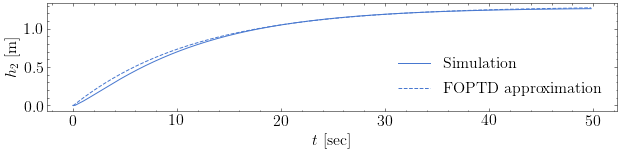

In [13]:
color = sns.color_palette(palette='muted')[0]
plt.figure(figsize=(9, 2.5))
plt.plot(t, y, c=color, label='Simulation')
plt.plot(t, y_taylor, c=color, linestyle='dashed', label='FOPTD approximation')
plt.xlabel(r'$t$ [sec]')
plt.ylabel(r'$h_{2}$ [m]')
plt.legend()
plt.tight_layout()

RMSE = (sum((y - y_taylor) ** 2) * dt / (tf - t0)) ** (1 / 2)
print(RMSE)

plt.savefig('./Figures/Ch2/FOPTD_Approximation.pdf', transparent=True)

## Direct Synthesis

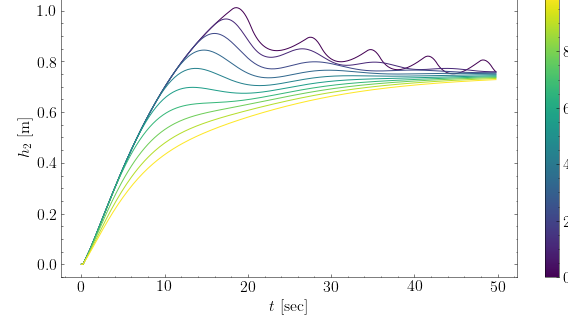

In [14]:
tauc_range = np.linspace(0, 10, 10)

fig, ax = plt.subplots(figsize=(9, 5))
norm = mpl.colors.Normalize(vmin=tauc_range.min(), vmax=tauc_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
cmap.set_array([])
Kcs = []
Kis = []
tvs = []
iaes = []
for tauc in tauc_range:
    Kc, Ki, Kd = tuning_rules(tau, K, theta, tau_c=tauc)
    Kcs.append(Kc)
    Kis.append(Ki)
    two_tanks = TwoTanks(fault_type=0, measurement_noise=0.0, process_noise=0.0)
    controller = PID(Kp=Kc, Ki=Ki, Kd=Kd, dt=dt, ref=0.75)
    u, x, y = two_tanks(t, [0.0, 0.0], controller)
    tvs.append(total_variation(u))
    iaes.append(IAE(y, np.ones_like(y) * 0.75, dt))
    im = ax.plot(t, y, c=cmap.to_rgba(tauc))
ax.set_xlabel(r'$t$ [sec]')
ax.set_ylabel(r'$h_{2}$ [m]')
fig.colorbar(cmap)
plt.tight_layout()
plt.savefig('./Figures/Ch2/DirectSynthesisTuning.pdf', transparent=True)

## Selecting an Optimal $\tau_{c}$

In [15]:
# Getting statistics
tauc_range = np.linspace(0.5, 10, 200)

Kcs = []
Kis = []
tvs = []
iaes = []
rise_times = []
overshootings = []
for tauc in tauc_range:
    Kc, Ki, Kd = tuning_rules(tau, K, theta, tau_c=tauc)
    Kcs.append(Kc)
    Kis.append(Ki)
    two_tanks = TwoTanks(fault_type=0, measurement_noise=0.0, process_noise=0.0)
    controller = PID(Kp=Kc, Ki=Ki, Kd=Kd, dt=dt, ref=0.75)
    u, x, y = two_tanks(t, [0.0, 0.0], controller)
    rise_times.append(rise_time(t, y))
    overshootings.append(overshooting(y))
    tvs.append(total_variation(u))
    iaes.append(IAE(y, np.ones_like(y) * 0.75, dt))

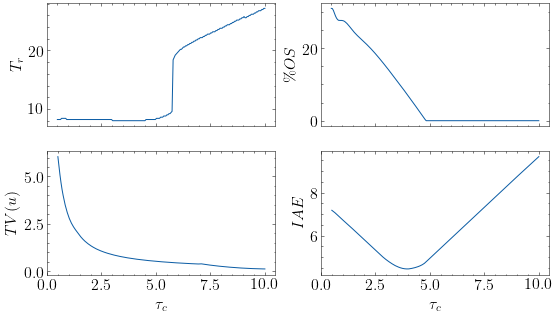

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(9, 5), sharex='col')

axes[0, 0].plot(tauc_range, rise_times)
axes[0, 0].set_ylabel(r'$T_{r}$')
axes[0, 1].plot(tauc_range, overshootings)
axes[0, 1].set_ylabel(r'$\%OS$')
axes[1, 0].plot(tauc_range, tvs)
axes[1, 0].set_ylabel(r'$TV(u)$')
axes[1, 0].set_xlabel(r'$\tau_{c}$')
axes[1, 1].plot(tauc_range, iaes)
axes[1, 1].set_ylabel(r'$IAE$')
axes[1, 1].set_xlabel(r'$\tau_{c}$')
_ = axes[1, 0].set_xticks([0.0, 2.5, 5, 7.5, 10])
_ = axes[1, 1].set_xticks([0.0, 2.5, 5, 7.5, 10])

plt.savefig('./Figures/Ch2/TuningTauc.pdf', transparent=True)

## Non-Linear System + PID

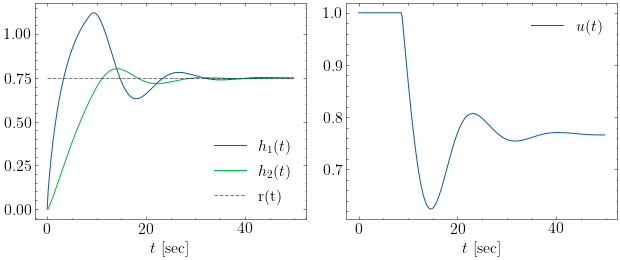

In [17]:
t0 = 0.0
tf = 50.0
dt = 0.2
t = np.arange(t0, tf, dt)
Kp, Ki, Kd = 2.1611152842430346, 0.1915584042916885, 0

two_tanks = TwoTanks(fault_type=0, measurement_noise=0.0, process_noise=0.0)
controller = PID(Kp=Kp, Ki=Ki, Kd=Kd, dt=dt, ref=0.75)

u, x, y = two_tanks(t, [0.0, 0.0], controller)
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(9, 4))
axes[0].plot(t, x[:, 0], label=r'$h_{1}(t)$')
axes[0].plot(t, x[:, 1], label=r'$h_{2}(t)$')
axes[0].plot(t, [0.75] * len(t), 'k--', label=r'r(t)', alpha=0.5)
axes[0].set_xlabel('$t$ [sec]')
axes[0].legend()
axes[1].plot(t, u, label=r'$u(t)$')
axes[1].legend()
axes[1].set_xlabel(r'$t$ [sec]')
plt.tight_layout()
plt.savefig('./Figures/Ch2/PID_Simulation.pdf', transparent=True)

## Process Noise

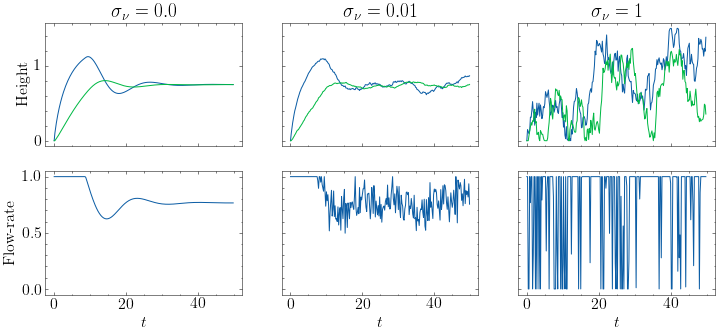

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(12, 5), sharey="row", sharex="col")

t0 = 0.0
tf = 50.0
dt = 0.2
t = np.arange(t0, tf, dt)
Kp, Ki, Kd = 2.1611152842430346, 0.1915584042916885, 0

two_tanks = TwoTanks(fault_type=0, measurement_noise=0.0, process_noise=0.0)
controller = PID(Kp=Kp, Ki=Ki, Kd=Kd, dt=dt, ref=0.75)

u, x, y = two_tanks(t, [0.0, 0.0], controller)
axes[0, 0].plot(t, x[:, 0])
axes[0, 0].plot(t, x[:, 1])
axes[0, 0].set_ylabel('Height')
axes[0, 0].set_title(r'$\sigma_{\nu} = 0.0$')
axes[1, 0].plot(t, u, label=r'$u(t)$')
axes[1, 0].set_xlabel(r'$t$')
axes[1, 0].set_ylabel('Flow-rate')

two_tanks = TwoTanks(fault_type=0, measurement_noise=5e-2, process_noise=5e-2)
controller = PID(Kp=Kp, Ki=Ki, Kd=Kd, dt=dt, ref=0.75)

u, x, y = two_tanks(t, [0.0, 0.0], controller)
axes[0, 1].plot(t, x[:, 0])
axes[0, 1].plot(t, x[:, 1])
axes[0, 1].set_title(r'$\sigma_{\nu} = 0.01$')
axes[1, 1].plot(t, u, label=r'$u(t)$')
axes[1, 1].set_xlabel(r'$t$')

two_tanks = TwoTanks(fault_type=0, measurement_noise=1, process_noise=1)
controller = PID(Kp=Kp, Ki=Ki, Kd=Kd, dt=dt, ref=0.75)

u, x, y = two_tanks(t, [0.0, 0.0], controller)
axes[0, 2].plot(t, x[:, 0])
axes[0, 2].plot(t, x[:, 1])
axes[0, 2].set_title(r'$\sigma_{\nu} = 1$')
axes[1, 2].plot(t, u, label=r'$u(t)$')
axes[1, 2].set_xlabel(r'$t$')

plt.savefig('./Figures/Ch2/RealSysSim.pdf', transparent=True)

## Example: $a_{12}$ obstruction

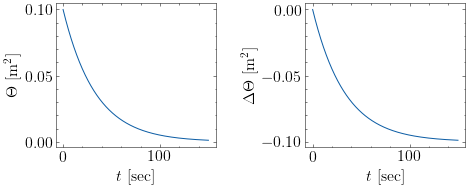

In [13]:
t = np.arange(0.0, 150.0, 0.2)
a0 = 0.1
a = a0 * np.exp(-0.03 * t)

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
axes[0].plot(t, a)
axes[0].set_ylabel('$\Theta$ [m$^{2}$]')
axes[0].set_xlabel('$t$ [sec]')

axes[1].plot(t, a - a0)
axes[1].set_ylabel('$\Delta\Theta$ [m$^{2}$]')
axes[1].set_xlabel('$t$ [sec]')
plt.tight_layout()

plt.savefig('./Figures/Ch2/ParameterFault.pdf')

In [14]:
Kp, Ki, Kd = 2.1611152842430346, 0.1915584042916885, 0

two_tanks = TwoTanks(fault_type=0, measurement_noise=5e-2, process_noise=5e-2)
controller = PID(Kp=Kp, Ki=Ki, Kd=Kd, dt=0.2, ref=0.75)
u, x, y = two_tanks(t, [0.0, 0.0], controller)

In [15]:
two_tanks = TwoTanks(fault_type=4, measurement_noise=5e-2, process_noise=5e-2)
controller = PID(Kp=Kp, Ki=Ki, Kd=Kd, dt=0.2, ref=0.75)
u1, x1, y1 = two_tanks(t, [0.0, 0.0], controller)

In [16]:
y.shape

(750,)

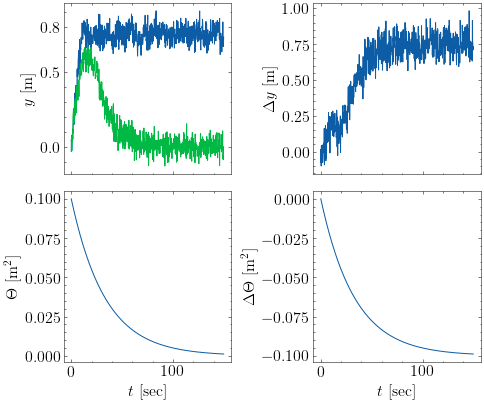

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex='col')
axes[0, 0].plot(t, y)
axes[0, 0].plot(t, y1)
axes[0, 0].set_ylabel('$y$ [m]')
# axes[0].set_xlabel('$t$')
axes[0, 0].set_yticks([0.0, 0.5, 0.8])

axes[0, 1].plot(t, y - y1)
axes[0, 1].set_ylabel('$\Delta y$ [m]')
# axes[1].set_xlabel('$t$')

axes[1, 0].plot(t, a)
axes[1, 0].set_ylabel('$\Theta$ [m$^{2}$]')
axes[1, 0].set_xlabel('$t$ [sec]')

axes[1, 1].plot(t, a - a0)
axes[1, 1].set_ylabel('$\Delta\Theta$ [m$^{2}$]')
axes[1, 1].set_xlabel('$t$ [sec]')
plt.tight_layout()

plt.savefig('./Figures/Ch2/ParameterFault.pdf', transparent=True)

## Faults

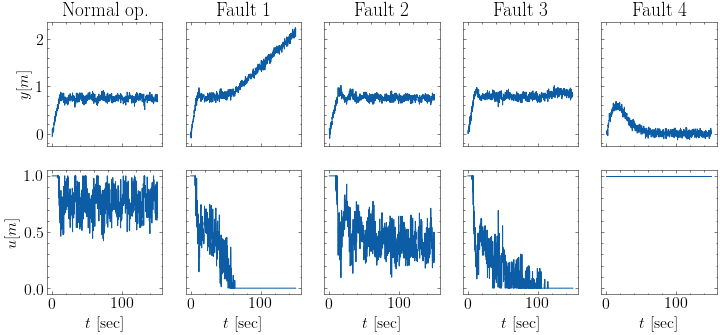

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5), sharey="row", sharex="col")

t0 = 0.0
tf = 150.0
dt = 0.2
t = np.arange(t0, tf, dt)
Kp, Ki, Kd = 2.1611152842430346, 0.1915584042916885, 0

for fault in range(5):
    two_tanks = TwoTanks(fault_type=fault, measurement_noise=5e-2, process_noise=5e-2)
    controller = PID(Kp=Kp, Ki=Ki, Kd=Kd, dt=dt, ref=0.75)

    u, x, y = two_tanks(t, [0.0, 0.0], controller)
    axes[0, fault].plot(t, y)
    if fault != 0:
        axes[0, fault].set_title('Fault {}'.format(fault))
    else:
        axes[0, fault].set_title('Normal op.')
    axes[1, fault].plot(t, u)
    axes[1, fault].set_xlabel(r'$t$ [sec]')
    
axes[0, 0].set_ylabel(r'$y [m]$')
axes[1, 0].set_ylabel(r'$u [m]$')
plt.savefig('./Figures/Ch2/TwoTanksFaultySim.pdf', transparent=True)

## Simulation for StepFn input


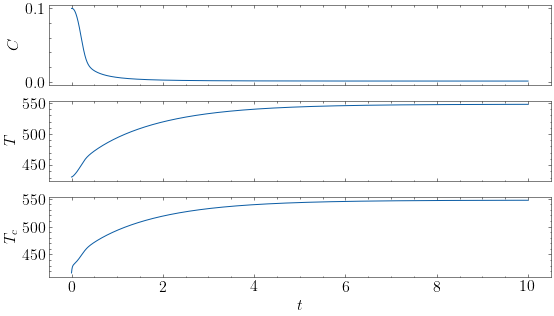

In [62]:
t = 0.0; tf = 10; dt = 1e-3; t = np.arange(t, tf, dt)  
x0 = np.array([0.1, 430.882699002514, 416.723084574301])
cstr = CSTR(process_noise=0.0, measurement_noise=0.0)
u, x, y = cstr(t, x0, u_fn=step_fn)
y = x[:, 1]

fig, axes = plt.subplots(3, 1, figsize=(9, 5), sharex=True)
axes[0].plot(t, x[:, 0])
axes[1].plot(t, x[:, 1])
axes[2].plot(t, x[:, 2])
axes[0].set_ylabel(r'$C$')
axes[1].set_ylabel(r'$T$')
axes[2].set_ylabel(r'$T_{c}$')
axes[2].set_xlabel(r'$t$')
plt.savefig('./Figures/Ch2/CSTR_StepResponse.pdf')

## Identification

In [63]:
# Sub-sampling signals
_t = t[::3]
_y = y[::3]

In [65]:
sysid = FOPTD()
sysid.fit(t, y)
tau, K, theta = sysid.predict()

## FOPTD System Simulation

In [66]:
s = control.TransferFunction.s
Gtaylor = (K * (1 - theta * s)) / (tau * s + 1)
_, y_taylor = control.step_response(Gtaylor, T=t)

36.57691263490923


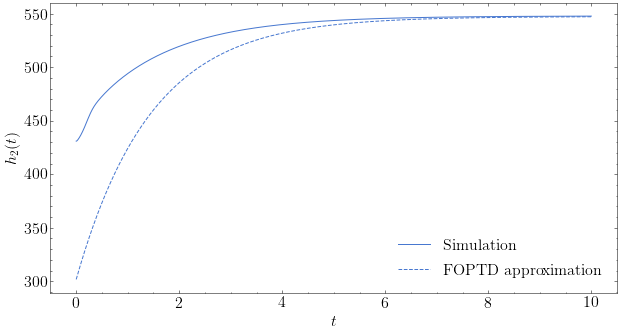

In [67]:
color = sns.color_palette(palette='muted')[0]
plt.figure(figsize=(9, 5))
plt.plot(t, y, c=color, label='Simulation')
plt.plot(t, y_taylor, c=color, linestyle='dashed', label='FOPTD approximation')
plt.xlabel(r'$t$')
plt.ylabel(r'$h_{2}(t)$')
plt.legend()
plt.tight_layout()

RMSE = (sum((y - y_taylor) ** 2) * dt / (tf - t0)) ** (1 / 2)
print(RMSE)

plt.savefig('./Figures/Ch2/CSTR_FOPTD_Approximation.pdf')

## Direct Synthesis

0.1 -0.003788034232681661 -0.002612839767767344 0
0.2 -0.004420174422085765 -0.0030488656651652536 0
0.3 -0.005305555825282234 -0.0036595675748667647 0
0.4 -0.006634471107230375 -0.004576202030466643 0
0.5 -0.008851581239756913 -0.006105479003152357 0
0.6 -0.013294263322550159 -0.009169869583712657 0
0.7 -0.026690393141882235 -0.018410002744110712 0
0.8 3.4832759132785203 2.402629244951991 0
0.9 0.02628753974298923 0.01813213002265362 0
1.0 0.013193554340585525 0.00910040441605965 0


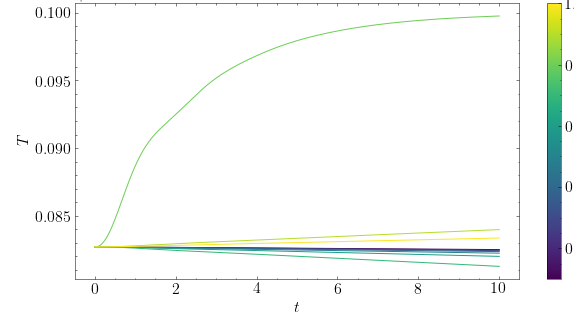

In [100]:
tauc_range = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

fig, ax = plt.subplots(figsize=(9, 5))
norm = mpl.colors.Normalize(vmin=tauc_range.min(), vmax=tauc_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
cmap.set_array([])
Kcs = []
Kis = []
tvs = []
iaes = []
for tauc in tauc_range:
    Kc, Ki, Kd = tuning_rules(tau, K, theta, tau_c=tauc)
    print(tauc, Kc, Ki, Kd)
    Kcs.append(Kc)
    Kis.append(Ki)
    cstr = CSTR(process_noise=0.0, measurement_noise=0.0)
    controller = PID(Kp=Kc, Ki=Ki, Kd=Kd, dt=dt, ref=430.9,
                     min_action=20, max_action=200, pos_ref=False,
                     initial_action=148.550238092053, implementation="recursive")
    u, x, y = cstr(t, x0, u_fn=controller)
    tvs.append(total_variation(u))
    iaes.append(IAE(x[:, 1], np.ones_like(x[:, 1]) * 430.9, dt))
    im = ax.plot(t, x[:, 1], c=cmap.to_rgba(tauc))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$T$')
fig.colorbar(cmap)
plt.tight_layout()
plt.savefig('./Figures/Ch2/CSTR_DirectSynthesisTuning.pdf')

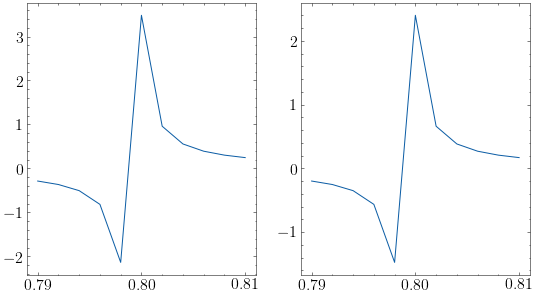

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
Kcs = []
Kis = []
for tau_c in np.linspace(0.79, 0.81, 11):
    Kc, Ki, Kd = tuning_rules(tau, K, theta, tau_c=tau_c)
    Kcs.append(Kc)
    Kis.append(Ki)
axes[0].plot(np.linspace(0.79, 0.81, 11), Kcs)
axes[1].plot(np.linspace(0.79, 0.81, 11), Kis)

In [94]:
tuning_rules(tau, K, theta, tau_c=0.795)

(-0.6247651481561142, -0.43093887867579267, 0)